In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0628/weights_KD_segformer_0628_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0628(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0628(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.3
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Position_Embedding_0628_teacher


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 733ms/step - loss: 0.0814
Average validation loss: 0.4426875114440918
4/4 [==============================] - 6s 756ms/step - loss: 0.0814 - val_loss: 0.4427
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 9s 768ms/step - loss: 0.0446 - val_loss: 0.4427
Average validation loss: 0.2593178153038025
4/4 [==============================] - 9s 782ms/step - loss: 0.0446 - val_loss: 0.3510
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 12s 720ms/step - loss: 0.0302 - val_loss: 0.3510
Average validation loss: 0.17825211584568024
4/4 [==============================] - 12s 733ms/step - loss: 0.0302 - val_los

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 5s 684ms/step - loss: 3.4724e-05
Average validation loss: 0.0
8/8 [==============================] - 6s 694ms/step - loss: 3.4724e-05 - val_loss: 0.0000e+00
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 11s 685ms/step - loss: 3.4210e-05 - val_loss: 0.0000e+00
Average validation loss: 0.0
8/8 [==============================] - 11s 697ms/step - loss: 3.4210e-05 - val_loss: 0.0000e+00
Epoch 3/10
8/8 [==============================] - 17s 677ms/step - loss: 3.3940e-05 - val_loss: 0.0000e+00
Average validation loss: 0.0
8/8 [==============================] - 17s 689ms/step - loss: 3.3940e-05 - val_loss: 0.0000e+00
Epoch 4/10
8/8 [==============================] - 22s 681ms/step - loss: 3.3711e-05 - val_loss: 0.0000e+00
Average validation loss: 2.76397230436487e-07
8/8 [======

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 8s 688ms/step - loss: 5.3245e-05
Average validation loss: 0.05485442653298378
12/12 [==============================] - 8s 699ms/step - loss: 5.3245e-05 - val_loss: 0.0549
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 705ms/step - loss: 4.7661e-05 - val_loss: 0.0549
Average validation loss: 0.04409517674624416
12/12 [==============================] - 17s 716ms/step - loss: 4.7661e-05 - val_loss: 0.0495
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 26s 700ms/step - loss: 5.2731e-05 - val_loss: 0.0495
Average validation loss: 0.031196509177486103
12/12 [==============================] - 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 702ms/step - loss: 3.8522e-05
Average validation loss: 0.047966475369321415
16/16 [==============================] - 12s 713ms/step - loss: 3.8522e-05 - val_loss: 0.0480
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 686ms/step - loss: 3.7924e-05 - val_loss: 0.0480
Average validation loss: 0.042696310571045615
16/16 [==============================] - 23s 697ms/step - loss: 3.7924e-05 - val_loss: 0.0453
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 34s 691ms/step - loss: 3.9384e-05 - val_loss: 0.0453
Average validation loss: 0.07117844284118746
16/16 [==============================]

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 696ms/step - loss: 3.5283e-05
Average validation loss: 0.04762616860680282
20/20 [==============================] - 14s 705ms/step - loss: 3.5283e-05 - val_loss: 0.0476
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 28s 682ms/step - loss: 2.6560e-05 - val_loss: 0.0476
Average validation loss: 0.048527162661775945
20/20 [==============================] - 28s 692ms/step - loss: 2.6560e-05 - val_loss: 0.0481
Epoch 3/10
20/20 [==============================] - 42s 688ms/step - loss: 2.2428e-05 - val_loss: 0.0481
Average validation loss: 0.05982204316824209
20/20 [==============================] - 42s 697ms/step - loss: 2.2428e-05 - val_loss: 0.0520
Epoch 4/10
20/20 [==============================] - 56s 685ms/step - loss: 2.0620e-05 - val_loss: 0.0520
Average validati

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 702ms/step - loss: 3.9213e-05
Average validation loss: 0.06473015062510967
24/24 [==============================] - 17s 713ms/step - loss: 3.9213e-05 - val_loss: 0.0647
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 34s 688ms/step - loss: 3.0047e-05 - val_loss: 0.0647
Average validation loss: 0.053156616166234016
24/24 [==============================] - 34s 697ms/step - loss: 3.0047e-05 - val_loss: 0.0589
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 50s 690ms/step - loss: 2.4138e-05 - val_loss: 0.0589
Average validation loss: 0.037851037457585335
24/24 [==============================]

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 27s 683ms/step - loss: 9.6735e-05
Average validation loss: 0.12587492763996125
40/40 [==============================] - 28s 693ms/step - loss: 9.6735e-05 - val_loss: 0.1259
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 55s 680ms/step - loss: 8.0056e-05 - val_loss: 0.1259
Average validation loss: 0.09079278614372015
40/40 [==============================] - 55s 690ms/step - loss: 8.0056e-05 - val_loss: 0.1083
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 83s 689ms/step - loss: 7.0699e-05 - val_loss: 0.1083
Average validation loss: 0.09587284997105598
40/40 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 33s 692ms/step - loss: 4.6490e-05
Average validation loss: 0.13019235770032841
48/48 [==============================] - 34s 702ms/step - loss: 4.6490e-05 - val_loss: 0.1302
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 67s 696ms/step - loss: 3.1716e-05 - val_loss: 0.1302
Average validation loss: 0.10027765977611125
48/48 [==============================] - 68s 706ms/step - loss: 3.1716e-05 - val_loss: 0.1152
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 101s 687ms/step - loss: 2.4656e-05 - val_loss: 0.1152
Average validation loss: 0.09398567430556189
48/48 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 38s 685ms/step - loss: 5.3964e-05
Average validation loss: 0.10146743936781734
56/56 [==============================] - 39s 696ms/step - loss: 5.3964e-05 - val_loss: 0.1015
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 78s 687ms/step - loss: 4.1320e-05 - val_loss: 0.1015
Average validation loss: 0.1423865532138799
56/56 [==============================] - 78s 697ms/step - loss: 4.1320e-05 - val_loss: 0.1219
Epoch 3/10
56/56 [==============================] - 116s 683ms/step - loss: 3.4179e-05 - val_loss: 0.1219
Average validation loss: 0.10560220088323799
56/56 [==============================] - 117s 693ms/step - loss: 3.4179e-05 - val_loss: 0.1165
Epoch 4/10
56/56 [==============================] - 156s 693ms/step - loss: 2.8851e-05 - val_loss: 0.1165
Average validat

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 47s 734ms/step - loss: 5.1223e-05
Average validation loss: 0.10878749211951799
64/64 [==============================] - 48s 744ms/step - loss: 5.1223e-05 - val_loss: 0.1088
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 95s 732ms/step - loss: 3.4068e-05 - val_loss: 0.1088
Average validation loss: 0.1109659543158159
64/64 [==============================] - 95s 742ms/step - loss: 3.4068e-05 - val_loss: 0.1099
Epoch 3/10
64/64 [==============================] - 142s 732ms/step - loss: 2.6428e-05 - val_loss: 0.1099
Average validation loss: 0.15650734694878388
64/64 [==============================] - 143s 742ms/step - loss: 2.6428e-05 - val_loss: 0.1254
Epoch 4/10
64/64 [==============================] - 190s 733ms/step - loss: 2.1731e-05 - val_loss: 0.1254
Average validat

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 53s 732ms/step - loss: 3.3474e-05
Average validation loss: 0.10262018193801244
72/72 [==============================] - 53s 742ms/step - loss: 3.3474e-05 - val_loss: 0.1026
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 106s 732ms/step - loss: 2.5216e-05 - val_loss: 0.1026
Average validation loss: 0.11316621469126807
72/72 [==============================] - 107s 743ms/step - loss: 2.5216e-05 - val_loss: 0.1079
Epoch 3/10
72/72 [==============================] - 160s 731ms/step - loss: 2.1733e-05 - val_loss: 0.1079
Average validation loss: 0.11247290153470305
72/72 [==============================] - 160s 742ms/step - loss: 2.1733e-05 - val_loss: 0.1094
Epoch 4/10
72/72 [==============================] - 213s 731ms/step - loss: 1.8318e-05 - val_loss: 0.1094
Average vali

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 55s 688ms/step - loss: 2.6334e-05
Average validation loss: 0.1885347381234169
80/80 [==============================] - 56s 698ms/step - loss: 2.6334e-05 - val_loss: 0.1885
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 111s 690ms/step - loss: 2.0401e-05 - val_loss: 0.1885
Average validation loss: 0.1841797422617674
80/80 [==============================] - 112s 700ms/step - loss: 2.0401e-05 - val_loss: 0.1864
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 167s 692ms/step - loss: 1.5856e-05 - val_loss: 0.1864
Average validation loss: 0.15427086241543292
80/80 [==============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 66s 685ms/step - loss: 5.7564e-05
Average validation loss: 0.18130880192230356
96/96 [==============================] - 67s 695ms/step - loss: 5.7564e-05 - val_loss: 0.1813
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 130s 656ms/step - loss: 3.8023e-05 - val_loss: 0.1813
Average validation loss: 0.15796452895519528
96/96 [==============================] - 131s 666ms/step - loss: 3.8023e-05 - val_loss: 0.1696
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 194s 663ms/step - loss: 2.9317e-05 - val_loss: 0.1696
Average validation loss: 0.18714509159673418
96/96 [============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 83s 688ms/step - loss: 3.2335e-05
Average validation loss: 0.12283613382654342
120/120 [==============================] - 84s 698ms/step - loss: 3.2335e-05 - val_loss: 0.1228
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 166s 688ms/step - loss: 2.1784e-05 - val_loss: 0.1228
Average validation loss: 0.11534640015500676
120/120 [==============================] - 168s 698ms/step - loss: 2.1784e-05 - val_loss: 0.1191
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 250s 684ms/step - loss: 1.7396e-05 - val_loss: 0.1191
Average validation loss: 0.13395585091302564
120/120 [================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 99s 686ms/step - loss: 2.5691e-05
Average validation loss: 0.12175074284030213
144/144 [==============================] - 100s 696ms/step - loss: 2.5691e-05 - val_loss: 0.1218
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 199s 684ms/step - loss: 1.7177e-05 - val_loss: 0.1218
Average validation loss: 0.11827335004020118
144/144 [==============================] - 200s 694ms/step - loss: 1.7177e-05 - val_loss: 0.1200
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 299s 684ms/step - loss: 1.3354e-05 - val_loss: 0.1200
Average validation loss: 0.16459630864934147
144/144 [===============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 109s 682ms/step - loss: 1.5867e-05
Average validation loss: 0.16986930467272982
160/160 [==============================] - 111s 692ms/step - loss: 1.5867e-05 - val_loss: 0.1699
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 220s 681ms/step - loss: 1.1962e-05 - val_loss: 0.1699
Average validation loss: 0.16666322802517933
160/160 [==============================] - 221s 691ms/step - loss: 1.1962e-05 - val_loss: 0.1683
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 330s 681ms/step - loss: 1.0125e-05 - val_loss: 0.1683
Average validation loss: 0.16008880492140207
160/160 [==============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 137s 685ms/step - loss: 4.8865e-05
Average validation loss: 0.1172173051855225
200/200 [==============================] - 139s 694ms/step - loss: 4.8865e-05 - val_loss: 0.1172
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 275s 683ms/step - loss: 3.4178e-05 - val_loss: 0.1172
Average validation loss: 0.14266340704503364
200/200 [==============================] - 277s 692ms/step - loss: 3.4178e-05 - val_loss: 0.1299
Epoch 3/10
200/200 [==============================] - 414s 683ms/step - loss: 2.6505e-05 - val_loss: 0.1299
Average validation loss: 0.1361510283581083
200/200 [==============================] - 416s 693ms/step - loss: 2.6505e-05 - val_loss: 0.1320
Epoch 4/10
200/200 [==============================] - 553s 682ms/step - loss: 2.2002e-05 - val_loss: 0.13

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:54 - loss: 1.4585e-05

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 164s 684ms/step - loss: 2.9182e-05
Average validation loss: 0.1717285108674434
240/240 [==============================] - 166s 693ms/step - loss: 2.9182e-05 - val_loss: 0.1717
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 330s 681ms/step - loss: 2.1724e-05 - val_loss: 0.1717
Average validation loss: 0.20844397571689888
240/240 [==============================] - 332s 691ms/step - loss: 2.1724e-05 - val_loss: 0.1901
Epoch 3/10
240/240 [==============================] - 496s 681ms/step - loss: 1.7291e-05 - val_loss: 0.1901
Average validation loss: 0.18021090328507536
240/240 [==============================] - 498s 691ms/step - loss: 1.7291e-05 - val_loss: 0.1868
Epoch 4/10
240/240 [==============================] - 662s 681ms/step - loss: 1.4316e-05 - val_loss: 0.1

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.04409078393078339, 0.04258532563700612, 0.06962352734305872, 0.06704949428656391, 0.04709596916762529, 0.04999604477776453, 0.08885969933235717, 0.09589470459995443, 0.10358251039638901, 0.10214069841277809, 0.11623089246303815, 0.14701909144223435, 0.132601373479354, 0.1472197615629816, 0.1462595257167276, 0.16304142237025168, 0.1766062415370155, 0.1775372501524802]
std_val_losses =  [0.07717686542903866, 0.039903506173835104, 0.03895307928678082, 0.024172898608874248, 0.018268431877930834, 0.024785178793054002, 0.020251449846027867, 0.01903250103082867, 0.025076409839677752, 0.0252003370987844, 0.03453295808216969, 0.06445651973721325, 0.03199214152872367, 0.04094625304353204, 0.02207060249560696, 0.028905190123009815, 0.029568862572720147, 0.018781152577561275]


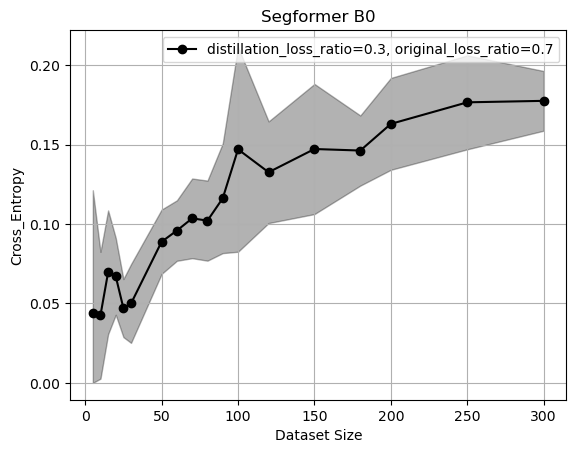

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0628')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0628_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0628_{int(teacher_ratio*100)}.png"))

plt.show()